In [1]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import re
import os
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import math
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from tensorflow import keras

### Loading Data From Database(MySQL)

In [3]:
username = 'cfb101spade'
password = pwd
host_port = host_port
database = 'twfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [4]:
# test

fruit = "banana"
market = "台北二"
df_test = pd.read_sql(f"{fruit}_{market}", engine)
df_test.tail()

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
3868,2021-08-04,37.9,5550.0,35.2,31.4,35.2,37.7
3869,2021-08-05,40.7,5530.0,38.0,29.3,37.9,38.3
3870,2021-08-06,38.3,5891.0,38.6,32.9,40.7,38.0
3871,2021-08-07,46.1,4681.0,42.3,29.9,38.3,39.6
3872,2021-08-08,47.5,4485.0,40.4,48.4,46.1,42.1


### LSTM模型訓練

##### 訓練集&測試集

In [22]:
def train_test_split(df):
    test_samples = int(df.shape[0]*0.2)
    
    # 訓練集
    train_data = df.iloc[:-test_samples, :]
    train_set = train_data.iloc[:, 1:].values           # 取得train_set(array)
 
    
    # 測試集
    test_data = df.iloc[-test_samples:, :]
    test_set = test_data.iloc[:, 1:].values             # 取得test_set(array)
       
    return train_set, test_set

In [23]:
a, b = train_test_split(df_test)
a

array([[   31.4,  9645. ,    36.5,    45. ,    31.4,    32.2],
       [   32. , 12230. ,    50. ,    47.5,    31.4,    32.2],
       [   32.2, 12103. ,    46.2,    47.5,    32. ,    32.2],
       ...,
       [   30.5, 12007.5,    30. ,    20.9,    29.7,    31.4],
       [   31.4, 10140. ,    32.5,    23.4,    30.5,    31. ],
       [   29.4, 13965. ,    27. ,    21. ,    31.4,    29.8]])

##### 資料標準化

In [5]:
def data_normalization(input_set):
    
    sc = StandardScaler()
    input_set_sc = sc.fit_transform(input_set[:, :])

    #sc_target = StandardScaler()
    #sc_target.fit_transform(input_set[:, 0:1])
    
    return input_set_sc #, sc_target

##### 創造X、y資料

In [6]:
def split_Xy(input_set_sc, n_future, n_past):
    X = []
    y = []

    for i in range(n_past, len(input_set_sc)-n_future+1): # 扣掉最後預測天數已符合y_test的length 
        X.append(input_set_sc[i-n_past:i, :])             # X = 前30天資料
        y.append(input_set_sc[i, :])                      # y = 後7天價格

    X, y = np.array(X), np.array(y) 
    
    print("X's shape: {}".format(X.shape))
    print("y's shape: {}".format(y.shape))
    
    return X, y

##### 建立模型

In [7]:
def model_creator(n_steps, n_features):
    model = Sequential()
    
    # 1st layer 
    # input_shape => n_step, n_feature 

    model.add(LSTM(units=64, activation="relu", input_shape=(n_steps, n_features), return_sequences=True)) 

    model.add(LSTM(units=32, activation="relu", return_sequences=False))          

    model.add(Dropout(0.2))

    model.add(Dense(y_train.shape[1]))          

    model.summary() 
     
    return model

##### 訓練模型

In [8]:
def model_trainer(model, X_train, y_train, epoch, batch_size):
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # 提升訓練效率
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, epochs=epoch, 
                        batch_size=batch_size,
                        callbacks=[es, rlr, mcp], 
                        validation_split=0.1, 
                        verbose=1)
    # 視覺化
#     plt.plot(history.history['loss'], label='Training loss')
#     plt.plot(history.history['val_loss'], label='Validation loss')
#     plt.legend()
    print("loss: ", history.history['loss'][-1])
    print("val_loss: ", history.history['val_loss'][-1])
    
    return model

##### 驗證模型準確率

In [14]:
def model_validation(model, X, y, sc_target):
    
    # 預測
    prediction = model.predict(X)
    prediction = sc_target.inverse_transform(prediction)
    actual = sc_target.inverse_transform(y)
    
    rmse_result = []
    for i in range(len(prediction)):
        rmse = mean_squared_error(prediction[i], actual[i], squared=False)
        rmse_result.append(rmse)

#     pd.DataFrame({"rmse":rmse_result}).plot()
    
    return prediction, actual

In [16]:
from my_libs.my_model_trainer import *

In [24]:
Type = "banana"
market = "台北二"

# parameter
n_future = 1
n_past = 30
epoch = 20
batch_size = 128 

# 讀取分析資料
df_merged = pd.read_sql(f"{Type}_{market}", engine)

# print(df_merged)
# 訓練集、測試集
train_set, test_set = train_test_split(df_merged)

train_set
### 訓練集part
# 訓練集(sc)、訓練集預測(scaler)
# train_set_sc = data_normalization(train_set)

# # 訓練集
# X_train, y_train = split_Xy(train_set_sc, n_future=n_future, n_past=n_past)

# # 創造momdel
# model = model_creator(n_steps=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

# # 訓練model
# trained_model = model_trainer(model, X_train, y_train, epoch=epoch, batch_size=batch_size)

array([[   31.4,  9645. ,    36.5,    45. ,    31.4,    32.2],
       [   32. , 12230. ,    50. ,    47.5,    31.4,    32.2],
       [   32.2, 12103. ,    46.2,    47.5,    32. ,    32.2],
       ...,
       [   30.5, 12007.5,    30. ,    20.9,    29.7,    31.4],
       [   31.4, 10140. ,    32.5,    23.4,    30.5,    31. ],
       [   29.4, 13965. ,    27. ,    21. ,    31.4,    29.8]])

In [30]:
train_set[-30:, :]

array([[3.71000e+01, 1.23370e+04, 3.57000e+01, 3.34000e+01, 3.69000e+01,
        3.67000e+01],
       [3.56000e+01, 1.26530e+04, 3.37000e+01, 3.17000e+01, 3.71000e+01,
        3.66000e+01],
       [3.95000e+01, 9.67500e+03, 3.56000e+01, 3.47000e+01, 3.56000e+01,
        3.71000e+01],
       [3.33000e+01, 1.69650e+04, 3.74000e+01, 3.27000e+01, 3.95000e+01,
        3.65000e+01],
       [3.52000e+01, 1.25490e+04, 3.68000e+01, 2.97000e+01, 3.33000e+01,
        3.61000e+01],
       [3.45000e+01, 1.86100e+04, 4.15000e+01, 3.23000e+01, 3.52000e+01,
        3.56000e+01],
       [3.55000e+01, 1.61750e+04, 4.18000e+01, 3.15000e+01, 3.45000e+01,
        3.56000e+01],
       [3.65000e+01, 1.37400e+04, 4.20000e+01, 3.07000e+01, 3.55000e+01,
        3.50000e+01],
       [3.62000e+01, 1.33600e+04, 3.68000e+01, 2.77000e+01, 3.65000e+01,
        3.56000e+01],
       [3.58000e+01, 1.16400e+04, 4.00000e+01, 2.75000e+01, 3.62000e+01,
        3.57000e+01],
       [3.84000e+01, 1.25100e+04, 4.12000e+01, 3.2

### 從SQL取資料進行模型訓練 => 完成後存成h5檔(共8個)

In [9]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

# parameter
n_future = 1
n_past = 30
epoch = 20
batch_size = 128 


pred_list = []
actual_list = []

for Fruit, Type in fruits.items():
    for market in markets:
        print(f"Ongoing: {Fruit}_{market}" + "==="*30)
        # 讀取分析資料
        df_merged = pd.read_sql(f"{Fruit}_{market}", engine)
    
        # 訓練集、測試集
        train_set, test_set = train_test_split(df_merged)

        ### 訓練集part
        # 訓練集(sc)、訓練集預測(scaler)
        train_set_sc = data_normalization(train_set)

        # 訓練集
        X_train, y_train = split_Xy(train_set_sc, n_future=n_future, n_past=n_past)

        # 創造momdel
        model = model_creator(n_steps=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

        # 訓練model
        trained_model = model_trainer(model, X_train, y_train, epoch=epoch, batch_size=batch_size)

        # 訓練集驗證
#         prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

        ### 測試集part
        # 測試集(sc)、測試集預測(scaler)
#         test_set_sc, sc_test_target = data_normalization(test_set)

#         # 測試集、test_scaler
#         X_test, y_test = split_Xy(test_set_sc, n_future=30, n_past=15)

#         # 測試集驗證
#         prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)
        
#         pred_list.append(prediction_test)
#         actual_list.append(actual_test)
        
        # 儲存模型
        #trained_model.save(f"C:/Users/Tibame/PycharmProjects/PythonETL/Fruit Price Prediction/models/{Fruit}_Price/{market}.h5")
        break
    break

Ongoing: banana_台北二==========================================================================================


TypeError: '(slice(None, None, None), slice(None, None, None))' is an invalid key

### Visualization

In [58]:
pred_list[i][-1]

array([31.253231, 31.387037, 32.614613, 31.7286  , 32.67921 , 32.271145,
       33.29961 , 33.05652 , 32.671246, 32.621914, 31.876493, 31.917885,
       32.833004, 32.723724, 33.09902 , 31.901978, 31.831924, 31.919737,
       31.136032, 31.569778, 31.99433 , 32.217827, 30.94789 , 30.216791,
       32.110744, 31.361824, 31.695175, 31.124853, 31.882736, 30.899582],
      dtype=float32)

In [59]:
actual_list[i][-1]

array([28. , 30.5, 29.4, 29.8, 29.2, 28.7, 30. , 29.4, 28.8, 27.6, 23.4,
       25.3, 27.2, 27.4, 25.1, 24.5, 21.7, 23.9, 22.1, 20.3, 20.5, 19.7,
       21.1, 17.6, 17.7, 17.8, 17.8, 19.7, 18.1, 19.4])

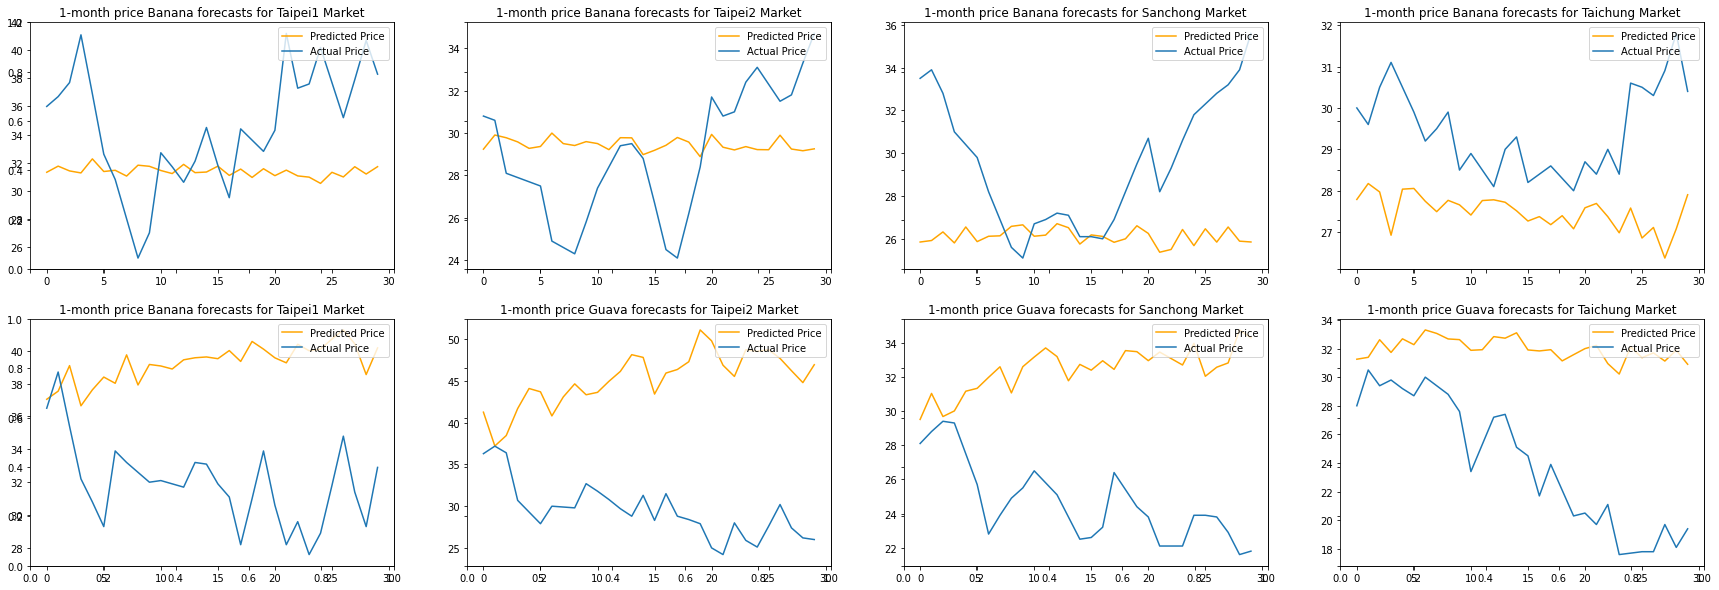

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(30,10), sharex=True, sharey=True) #, squeeze=True)

#     ax.xaxis.set_major_locator(plt.NullLocator())
#     ax.yaxis.set_major_locator(plt.NullLocator())

markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
fruits = ["Banana", "Guava"]

for i in list(range(8)):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(np.arange(30), pred_list[i][-1], label="Predicted Price", color="orange")
    ax.plot(np.arange(30), actual_list[i][-1], label="Actual Price")
    ax.set_xticks(np.arange(0, 31, 5))
    if i <= 4:
        fruit = fruits[0]
    else:
        fruit = fruits[1]
        
    ax.set_title(f"1-month price {fruit} forecasts for {markets[i%4]} Market")
    #ax.set_yticks(np.arange(0, 50, 10))
    
    ax.legend(loc="upper right")
    
    

### 預測結果評估(rmse, mape, mad)
- mape : 平均絕對百分比誤差(Mean absolute percentage error)
- rmse : 均方根差(root-mean-square error)
- mad : 平均絕對偏差（Mean Absolute Deviation)

In [56]:
# mean_absolute_percentage_error => 版本問題無法import
from sklearn.metrics import mean_squared_error

In [32]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
def mad(y_true, y_pred):
    return sum(np.abs((y_true - y_pred) / len(y_true)))

In [54]:
markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
fruits = ["Banana", "Guava"]

indexs = []
for f in fruits:
    for m in markets:
        indexs.append(f"{f}_{m}")


In [55]:
rmse_output = []
mape_output = []
mad_output = []

for i in list(range(8)):
    rmse_output.append(mean_squared_error(pred_list[i][-1], actual_list[i][-1], squared=False))
    mape_output.append(mape(actual_list[i][-1], pred_list[i][-1]))
    mad_output.append(mad(pred_list[i][-1], actual_list[i][-1]))

indexs = ['Banana_Taipei1', 'Banana_Taipei2', 'Banana_Sanchong', 'Banana_Taichung',
        'Guava_Taipei1', 'Guava_Taipei2', 'Guava_Sanchong','Guava_Taichung']

df_result_evaluation = pd.DataFrame({"RMSE" : rmse_output,
                                     "MAPE" : mape_output,
                                     "MAD" : mad_output}, index= indexs)

df_result_evaluation

,RMSE,MAPE,MAD
Banana_Taipei1,5.254433,12.150325,4.351217
Banana_Taipei2,3.071305,9.232211,2.581610
Banana_Sanchong,4.576449,11.400666,3.602571
Banana_Taichung,2.256509,6.489130,1.944239
Guava_Taipei1,7.901891,23.929959,7.405178
Guava_Taipei2,16.893634,56.240030,15.817361
Guava_Sanchong,8.431280,32.882585,7.773472
Guava_Taichung,8.883034,37.322462,7.904815


### 從SQL取分析資料進行價格預測
- 直接透過query取得資料進行分析
- 預測結果存入DB

In [18]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

pred_output = []
actual_output = []

for Fruit, Type in fruits.items():
    for market in markets:
        
        product = Type[0]
        same = Type[1]
        sub = Type[2]
        
        # 從SQL讀取分析資料，轉換成矩陣
        df_set = pd.read_sql_query(f"""select `{product}_平均價`, `{product}_交易量`, `{same}_平均價`, 
                                       `{sub}_平均價`, `{product}_前日平均價`, `{product}_5日平均價` 
                                       from {product}_{market}
                                       order by `日期` desc
                                       limit 30""", con).values 
        
        # 標準化
        df_set_sc, sc_target = data_normalization(df_set)
        
        # reshape => 需符合input的shape
        df_set_sc = df_set_sc.reshape(-1, 30, 6)
        
        # 載入model
        model_loaded = keras.models.load_model(f"models/{product}_Price/{market}.h5")
        
        # 進行預測
        pred_result = model_loaded(df_set_sc) # 使用model_loaded.predict(df_set_sc)會跳出tensorflow warning
        
        # 透過inverse_transform還原為原本數值
        output = sc_target.inverse_transform(pred_result).reshape(-1).round(1)
        
        print(f"{Fruit}_{market}市場未來7日預測價: ", output)
        
        

banana_台北二市場未來7日預測價:  [35.8 35.9 36.1 35.7 35.8 36.2 36.1]
banana_台北一市場未來7日預測價:  [29.2 29.1 29.4 29.5 29.6 29.4 29.3]
banana_三重區市場未來7日預測價:  [30.2 30.1 30.1 29.9 30.5 30.5 30.2]
banana_台中市市場未來7日預測價:  [30.1 30.2 30.1 30.2 30.1 30.2 30.2]
guava_台北二市場未來7日預測價:  [37.3 36.7 36.9 37.  37.7 37.6 37.9]
guava_台北一市場未來7日預測價:  [36.3 36.6 36.1 36.9 36.7 36.2 37. ]
guava_三重區市場未來7日預測價:  [29.4 29.2 29.3 29.2 30.  29.3 29.7]
guava_台中市市場未來7日預測價:  [28.4 29.2 29.6 29.2 29.  28.9 29.1]
